# SPF Optimal Beta for LEDH Particle Filter Experiment

# Experiment: Using SPF Optimal Particle Flow as Proposal for LEDH

## Research Question
**Does using the optimized particle flow from SPF (Stochastic Particle Filter) as the proposal distribution for LEDH (Local-Exact Daum-Huang) particle flow particle filter improve the LEDH filter's performance?**

## Background

### LEDH Particle Flow Filter
- Uses **per-particle linearization** at $\eta_\lambda^i$ (the particle position)
- Employs **fixed covariance** $P$ from EKF/UKF prediction throughout the flow
- Deterministic flow with Jacobian-based weight correction: $\theta^i = \prod |\det(I + \epsilon_j A^i)|$
- Linear schedule: $\beta(\lambda) = \lambda$ (typically)

### SPF (Stochastic Particle Filter)
- Solves for **optimal $\beta(\lambda)$** that minimizes stiffness (condition number)
- Uses ODE: $\beta'' = \mu \frac{d\kappa}{d\beta}$ where $\kappa$ is the condition number of $M(\beta) = M_0 + \beta M_h$
- Provides smoother, better-conditioned particle flow
- Includes stochastic diffusion to prevent particle collapse

## Hypothesis
The optimized $\beta(\lambda)$ from SPF should:
1. **Reduce stiffness** in LEDH's flow equations by avoiding rapid changes
2. **Improve numerical stability** during integration
3. **Lead to better particle diversity** and lower weight degeneracy
4. **Improve estimation accuracy** (lower RMSE)

## Proposed Experimental Design

### Test Scenarios
1. **Linear-Gaussian Bearing-Only Tracking** (from SPF paper Example 1)
   - 2D target position estimation
   - Two bearing-only sensors
   - Controlled stiffness scenario

2. **Stochastic Volatility Model** (from existing LEDH experiments)
   - Nonlinear state-space model
   - Challenging for particle filters
   - Good test for flow quality

### Comparison Methods
1. **LEDH-Linear**: Standard LEDH with linear schedule $\beta(\lambda) = \lambda$
2. **LEDH-Optimal**: Modified LEDH using SPF's optimal $\beta(\lambda)$
3. **SPF-Baseline**: Original SPF for reference
4. **Standard PF**: Bootstrap particle filter baseline

### Performance Metrics
1. **RMSE**: Root mean squared error vs. true state
2. **Log-likelihood**: Average log-likelihood of observations
3. **ESS**: Effective sample size (particle diversity)
4. **Condition Numbers**: Track $\kappa(S_i)$ during flow
5. **Computational Cost**: Runtime comparison
6. **Stability**: Track numerical issues (NaN, Inf, negative determinants)

### Experimental Parameters

#### Fixed Parameters (for fair comparison)
- Number of particles: $N \in \{100, 256, 512\}$
- Number of flow steps: $n_\lambda \in \{8, 16, 32\}$
- Monte Carlo trials: 100 runs per configuration
- Random seeds: controlled for reproducibility

#### SPF-specific Parameters
- Stiffness weight: $\mu = 0.2$ (from paper)
- Diffusion covariance: $Q = \text{diag}(4.0, 0.4)$ (from paper)
- Grid resolution for $\beta(\lambda)$ solving: 501 points

### Implementation Plan

#### Step 1: Extract SPF Optimal Beta
Create utility function to:
- Initialize SPF model structure (LinearGaussianBayes)
- Solve for optimal $\beta(\lambda)$ using `solve_beta_star_bisection`
- Return $\lambda$ grid, $\beta$ grid, $\beta'$ grid

#### Step 2: Modify LEDH Flow
Create modified LEDH class that:
- Accepts optional $\beta(\lambda)$ schedule
- Uses non-uniform $\lambda$ steps if needed
- Otherwise identical to standard LEDH

#### Step 3: Run Experiments
For each scenario and configuration:
- Generate/load test data
- Run LEDH-Linear (baseline)
- Compute optimal $\beta(\lambda)$ for the measurement update
- Run LEDH-Optimal with this schedule
- Collect all metrics
- Statistical significance testing (paired t-test)

#### Step 4: Analysis
- Plot RMSE vs. number of particles
- Plot condition numbers over $\lambda$
- Show $\beta(\lambda)$ schedules
- Particle trajectory visualization
- Statistical tables (mean ± std, p-values)

## Implementation: Utility Functions

In [8]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, Optional, Callable
import time

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

# Import necessary modules
from models.Stochastic_particle_filter import (
    LinearGaussianBayes, 
    solve_beta_star_bisection,
    kappa2_and_derivative
)
from models.LEDH_particle_filter import LEDHFlowPF, LEDHConfig, PFState
from models.extended_kalman_filter import ExtendedKalmanFilter
from models.unscented_kalman_filter import UnscentedKalmanFilter

print("✓ Imports successful!")

✓ Imports successful!


In [ ]:
def compute_optimal_beta_for_ledh(
    m_pred: np.ndarray,
    P_pred: np.ndarray,
    H: np.ndarray,
    R: np.ndarray,
    z: np.ndarray,
    mu: float = 0.2,
    n_steps: int = 16,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Compute optimal beta(lambda) schedule for LEDH using SPF's method.

    This function creates a LinearGaussianBayes model at the prediction step
    and solves for the optimal beta schedule that minimizes stiffness.

    Args:
        m_pred (np.ndarray): Predicted mean from EKF/UKF of shape (n,).
        P_pred (np.ndarray): Predicted covariance from EKF/UKF of shape (n, n).
        H (np.ndarray): Measurement Jacobian of shape (d, n).
        R (np.ndarray): Measurement noise covariance of shape (d, d).
        z (np.ndarray): Current observation of shape (d,).
        mu (float, optional): Stiffness mitigation parameter. Defaults to 0.2 from paper.
        n_steps (int, optional): Number of lambda steps. Defaults to 16.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Lambda values [0, 1] with n_steps+1 points,
            corresponding beta values, and corresponding beta' values.
    """
    # Create LinearGaussianBayes model for SPF's optimal beta solver
    # Prior: x ~ N(m_pred, P_pred)
    # Likelihood: z | x ~ N(H x, R)
    model = LinearGaussianBayes(
        m0=m_pred,
        P0=P_pred,
        H=H,
        R=R,
        z=z
    )
    
    # Solve for optimal beta using SPF's bisection method
    lam_grid, beta_grid, betadot_grid = solve_beta_star_bisection(
        M0=model.M0,
        Mh=model.Mh,
        mu=mu,
        n_grid=n_steps + 1
    )
    
    return lam_grid, beta_grid, betadot_grid


def visualize_beta_schedules(
    lam_linear: np.ndarray,
    beta_linear: np.ndarray,
    lam_optimal: np.ndarray,
    beta_optimal: np.ndarray,
    betadot_optimal: np.ndarray,
    title: str = "Beta Schedule Comparison"
):
    """Visualize linear vs optimal beta schedules.

    Args:
        lam_linear (np.ndarray): Lambda values for linear schedule.
        beta_linear (np.ndarray): Beta values for linear schedule.
        lam_optimal (np.ndarray): Lambda values for optimal schedule.
        beta_optimal (np.ndarray): Beta values for optimal schedule.
        betadot_optimal (np.ndarray): Beta derivative values for optimal schedule.
        title (str, optional): Plot title. Defaults to "Beta Schedule Comparison".
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Beta(lambda)
    axes[0].plot(lam_linear, beta_linear, 'b--', linewidth=2, label='Linear', alpha=0.7)
    axes[0].plot(lam_optimal, beta_optimal, 'r-', linewidth=2, label='Optimal')
    axes[0].set_xlabel(r'$\lambda$', fontsize=12)
    axes[0].set_ylabel(r'$\beta(\lambda)$', fontsize=12)
    axes[0].set_title(r'$\beta(\lambda)$ Schedule')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim([0, 1])
    axes[0].set_ylim([0, 1])
    
    # Beta'(lambda)
    axes[1].plot(lam_linear, np.ones_like(lam_linear), 'b--', linewidth=2, label='Linear', alpha=0.7)
    axes[1].plot(lam_optimal, betadot_optimal, 'r-', linewidth=2, label='Optimal')
    axes[1].set_xlabel(r'$\lambda$', fontsize=12)
    axes[1].set_ylabel(r"$\beta'(\lambda)$", fontsize=12)
    axes[1].set_title(r"$\beta'(\lambda)$ (Rate of Change)")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([0, 1])
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def compute_condition_number_profile(
    M0: np.ndarray,
    Mh: np.ndarray,
    beta_grid: np.ndarray
) -> np.ndarray:
    """Compute condition numbers along beta schedule.

    Args:
        M0 (np.ndarray): M0 matrix from LinearGaussianBayes.
        Mh (np.ndarray): Mh matrix from LinearGaussianBayes.
        beta_grid (np.ndarray): Beta values to evaluate.

    Returns:
        np.ndarray: Array of condition numbers at each beta value.
    """
    n = M0.shape[0]
    kappa_values = np.zeros(len(beta_grid))
    
    for i, beta in enumerate(beta_grid):
        M = M0 + beta * Mh
        # Use same method as SPF for consistency
        kappa, _ = kappa2_and_derivative(M, Mh)
        kappa_values[i] = kappa
        
    return kappa_values


print("✓ Utility functions defined!")

✓ Utility functions defined!


In [ ]:
class LEDHFlowPF_CustomBeta(LEDHFlowPF):
    """Extended LEDH that accepts custom beta(lambda) schedules.

    This allows us to use SPF's optimal beta schedule instead of
    the default linear schedule.
    """

    def step_with_custom_beta(
        self,
        state: PFState,
        z_k: np.ndarray,
        lam_grid: np.ndarray,
        beta_grid: np.ndarray,
        u_km1: Optional[np.ndarray] = None,
        process_noise_sampler: Optional[Callable[[int, int], np.ndarray]] = None,
    ) -> PFState:
        """Run one LEDH step with custom beta(lambda) schedule.

        Args:
            state (PFState): Current particle filter state.
            z_k (np.ndarray): Current observation.
            lam_grid (np.ndarray): Lambda values (should start at 0, end at 1).
            beta_grid (np.ndarray): Corresponding beta values (should start at 0, end at 1).
            u_km1 (np.ndarray, optional): Control input. Defaults to None.
            process_noise_sampler (Callable, optional): Function to sample process noise.
                Defaults to None.

        Returns:
            PFState: Updated particle filter state.
        """
        N, nx = state.particles.shape
        I = np.eye(nx)
        
        # Validate beta schedule
        assert len(lam_grid) == len(beta_grid), "Lambda and beta grids must match"
        assert np.isclose(lam_grid[0], 0.0), "Lambda must start at 0"
        assert np.isclose(lam_grid[-1], 1.0), "Lambda must end at 1"
        assert np.isclose(beta_grid[0], 0.0), "Beta must start at 0"
        assert np.isclose(beta_grid[-1], 1.0), "Beta must end at 1"
        
        n_steps = len(lam_grid) - 1

        # EKF/UKF prediction
        m_pred, P = self.tracker.predict()
        P = 0.5 * (P + P.T)

        # Propagate particles
        if process_noise_sampler is None:
            v = np.zeros((N, nx))
        else:
            v = process_noise_sampler(N, nx)
        
        eta0 = np.empty_like(state.particles)
        for i in range(N):
            eta0[i] = self.g(state.particles[i], u_km1, v[i])

        # Initialize flow variables
        eta = eta0.copy()
        etabar = eta0.copy()
        theta_log = np.zeros(N)
        cond_numbers = []

        # Flow integration with custom beta schedule
        for step_idx in range(n_steps):
            lam = lam_grid[step_idx + 1]
            beta = beta_grid[step_idx + 1]
            dlam = lam_grid[step_idx + 1] - lam_grid[step_idx]
            
            for i in range(N):
                # Linearize at particle position
                Hi = self.Jh(eta[i])
                h_eta_i = self.h(eta[i])
                ei = h_eta_i - Hi @ eta[i]

                # Use beta from custom schedule
                Si = beta * Hi @ P @ Hi.T + self.R
                
                # Track condition number
                if i == 0:
                    try:
                        cond_Si = np.linalg.cond(Si)
                        cond_numbers.append(float(cond_Si))
                    except:
                        cond_numbers.append(np.nan)
                
                Si_inv_Hi = np.linalg.solve(Si, Hi)
                Ai = -0.5 * P @ Hi.T @ Si_inv_Hi

                # Note: Original LEDH uses lambda in b_i calculation
                # We keep lambda for the innovation weighting
                Rin_innov_i = np.linalg.solve(self.R, (z_k - ei))
                PHt_Rinv_innov_i = P @ Hi.T @ Rin_innov_i
                bi = (I + 2.0 * lam * Ai) @ ((I + lam * Ai) @ PHt_Rinv_innov_i + Ai @ eta0[i])

                # Migrate particles
                etabar[i] = etabar[i] + dlam * (Ai @ etabar[i] + bi)
                eta[i] = eta[i] + dlam * (Ai @ eta[i] + bi)

                # Accumulate Jacobian
                M = I + dlam * Ai
                sign, logdet = np.linalg.slogdet(M)
                if sign <= 0:
                    sign, logdet = np.linalg.slogdet(M + 1e-12 * I)
                theta_log[i] += logdet

        # Set final particles
        xk = eta

        # Compute weights
        logw = np.log(state.weights + 1e-300) + theta_log
        for i in range(N):
            num = self.log_trans_pdf(xk[i], state.particles[i]) + self.log_like_pdf(z_k, xk[i])
            den = self.log_trans_pdf(eta0[i], state.particles[i])
            logw[i] += (num - den)
        
        logw -= np.max(logw)
        w = np.exp(logw)
        w /= np.sum(w)

        # EKF/UKF update
        self.tracker.update(z_k)

        # Optional resampling
        if self.cfg.resample_ess_ratio > 0.0:
            ess = 1.0 / np.sum(w * w)
            if ess < self.cfg.resample_ess_ratio * N:
                # Systematic resampling
                positions = (self.cfg.rng.random() + np.arange(N)) / N
                cdf = np.cumsum(w)
                idx = np.searchsorted(cdf, positions)
                xk = xk[idx]
                w = np.full_like(w, 1.0 / N)

        # Compute statistics
        mean = np.sum(xk * w[:, None], axis=0)
        xc = xk - mean[None, :]
        cov = (xc.T * w) @ xc
        cov = 0.5 * (cov + cov.T)
        
        diagnostics = {'condition_numbers': cond_numbers}
        
        return PFState(particles=xk, weights=w, mean=mean, cov=cov, diagnostics=diagnostics)


print("✓ LEDHFlowPF_CustomBeta class defined!")

✓ LEDHFlowPF_CustomBeta class defined!


## Experiment 1: Simple Bearing-Only Tracking

This experiment uses the linear-Gaussian bearing-only tracking problem from the SPF paper.

In [4]:
# Define the bearing-only tracking model from SPF paper
# This is Example 1 from "Stiffness Mitigation in Stochastic Particle Flow Filters"

# True state
x_true = np.array([4.0, 4.0])

# Sensors at (3.5, 0) and (-3.5, 0)
sensors = np.array([[3.5, 0.0], [-3.5, 0.0]])

# Prior
x_prior = np.array([3.0, 5.0])
P_prior = np.diag([1000.0, 2.0])

# Measurement noise
R = 0.04 * np.eye(2)

# Observation (from paper)
z_obs = np.array([0.4754, 1.1868])

# SPF parameters
mu = 0.2
Q_spf = np.diag([4.0, 0.4])

print("Bearing-Only Tracking Problem Setup:")
print(f"  True state: {x_true}")
print(f"  Prior mean: {x_prior}")
print(f"  Prior cov: diag({P_prior[0,0]:.1f}, {P_prior[1,1]:.1f})")
print(f"  Observation: {z_obs}")
print(f"  Sensors: {sensors}")
print(f"  R: {R[0,0]:.3f} * I_2")
print(f"  SPF mu: {mu}")
print(f"  SPF Q: diag({Q_spf[0,0]:.1f}, {Q_spf[1,1]:.1f})")

Bearing-Only Tracking Problem Setup:
  True state: [4. 4.]
  Prior mean: [3. 5.]
  Prior cov: diag(1000.0, 2.0)
  Observation: [0.4754 1.1868]
  Sensors: [[ 3.5  0. ]
 [-3.5  0. ]]
  R: 0.040 * I_2
  SPF mu: 0.2
  SPF Q: diag(4.0, 0.4)


In [5]:
# Bearing measurement functions

def bearing_measurement(x: np.ndarray, sensors: np.ndarray) -> np.ndarray:
    """
    Compute bearing angles from target position x to all sensors.
    
    Args:
        x: Target position [x_t, y_t] (2,)
        sensors: Sensor positions (n_sensors, 2)
    
    Returns:
        Bearing angles (n_sensors,)
    """
    dx = x[0] - sensors[:, 0]  # x_t - x_i
    dy = x[1] - sensors[:, 1]  # y_t - y_i
    bearings = np.arctan2(dy, dx)
    return bearings


def bearing_jacobian(x: np.ndarray, sensors: np.ndarray) -> np.ndarray:
    """
    Compute Jacobian of bearing measurement function.
    
    Args:
        x: Target position [x_t, y_t] (2,)
        sensors: Sensor positions (n_sensors, 2)
    
    Returns:
        Jacobian matrix (n_sensors, 2)
    """
    dx = x[0] - sensors[:, 0]
    dy = x[1] - sensors[:, 1]
    r_sq = dx**2 + dy**2
    
    # ∂(arctan(dy/dx))/∂x_t = -dy / (dx² + dy²)
    # ∂(arctan(dy/dx))/∂y_t = dx / (dx² + dy²)
    H = np.zeros((len(sensors), 2))
    H[:, 0] = -dy / r_sq
    H[:, 1] = dx / r_sq
    return H


# Test the functions
x_test = np.array([4.0, 4.0])
h_test = bearing_measurement(x_test, sensors)
H_test = bearing_jacobian(x_test, sensors)

print(f"\nTest at x={x_test}:")
print(f"  Bearings: {h_test}")
print(f"  Jacobian shape: {H_test.shape}")
print(f"  H = \n{H_test}")


Test at x=[4. 4.]:
  Bearings: [1.44644133 0.48995733]
  Jacobian shape: (2, 2)
  H = 
[[-0.24615385  0.03076923]
 [-0.05536332  0.10380623]]


Computing optimal beta schedule...
✓ Optimal beta computed!
  Lambda grid: 17 points from 0.000 to 1.000
  Beta range: [0.000, 1.000]
  Beta' range: [0.882, 1166.102]


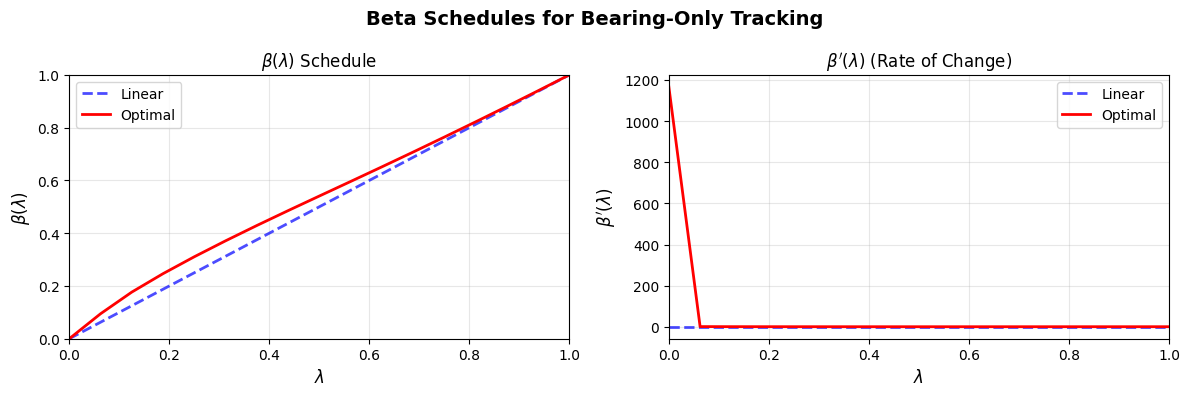

In [6]:
# Compute optimal beta schedule for this problem

# First, we need to linearize around the prior mean
H_prior = bearing_jacobian(x_prior, sensors)

print("Computing optimal beta schedule...")
lam_opt, beta_opt, betadot_opt = compute_optimal_beta_for_ledh(
    m_pred=x_prior,
    P_pred=P_prior,
    H=H_prior,
    R=R,
    z=z_obs,
    mu=mu,
    n_steps=16
)

# Create linear schedule for comparison
lam_lin = lam_opt.copy()
beta_lin = lam_lin.copy()
betadot_lin = np.ones_like(lam_lin)

print(f"✓ Optimal beta computed!")
print(f"  Lambda grid: {len(lam_opt)} points from {lam_opt[0]:.3f} to {lam_opt[-1]:.3f}")
print(f"  Beta range: [{beta_opt.min():.3f}, {beta_opt.max():.3f}]")
print(f"  Beta' range: [{betadot_opt.min():.3f}, {betadot_opt.max():.3f}]")

# Visualize the schedules
visualize_beta_schedules(
    lam_lin, beta_lin, 
    lam_opt, beta_opt, betadot_opt,
    title="Beta Schedules for Bearing-Only Tracking"
)

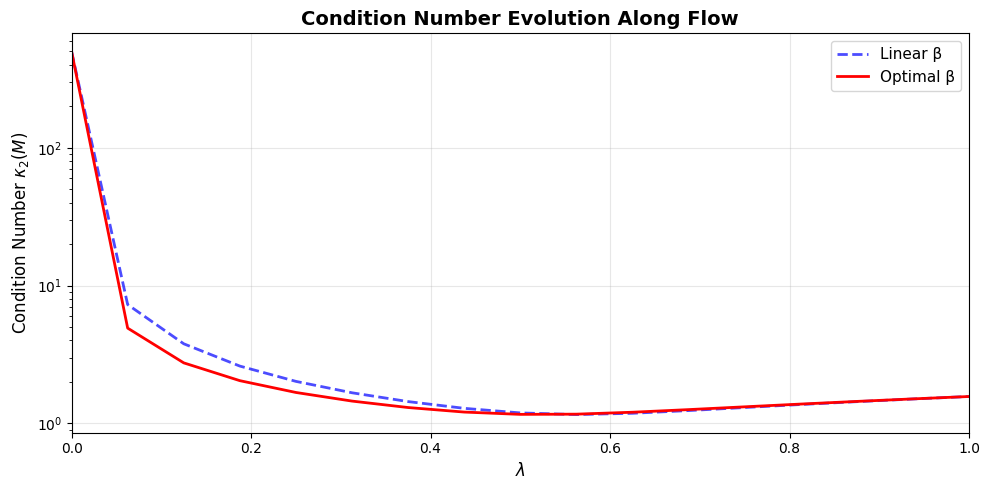

Condition Number Statistics:
  Linear schedule:
    Max: 5.00e+02
    Mean: 3.13e+01
    Std: 1.17e+02
  Optimal schedule:
    Max: 5.00e+02
    Mean: 3.10e+01
    Std: 1.17e+02
  Improvement: 1.00x reduction in max kappa


In [7]:
# Compute and visualize condition numbers along the schedules

# Create LinearGaussianBayes model
model = LinearGaussianBayes(
    m0=x_prior,
    P0=P_prior,
    H=H_prior,
    R=R,
    z=z_obs
)

# Compute condition numbers
kappa_lin = compute_condition_number_profile(model.M0, model.Mh, beta_lin)
kappa_opt = compute_condition_number_profile(model.M0, model.Mh, beta_opt)

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(lam_lin, kappa_lin, 'b--', linewidth=2, label='Linear β', alpha=0.7)
ax.semilogy(lam_opt, kappa_opt, 'r-', linewidth=2, label='Optimal β')
ax.set_xlabel(r'$\lambda$', fontsize=12)
ax.set_ylabel(r'Condition Number $\kappa_2(M)$', fontsize=12)
ax.set_title('Condition Number Evolution Along Flow', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
plt.tight_layout()
plt.show()

print(f"Condition Number Statistics:")
print(f"  Linear schedule:")
print(f"    Max: {kappa_lin.max():.2e}")
print(f"    Mean: {kappa_lin.mean():.2e}")
print(f"    Std: {kappa_lin.std():.2e}")
print(f"  Optimal schedule:")
print(f"    Max: {kappa_opt.max():.2e}")
print(f"    Mean: {kappa_opt.mean():.2e}")
print(f"    Std: {kappa_opt.std():.2e}")
print(f"  Improvement: {kappa_lin.max() / kappa_opt.max():.2f}x reduction in max kappa")

## Running the Experiment: LEDH Linear vs Optimal Beta

Now let's actually run both filters and compare their performance.

In [8]:
# Since this is a single-step problem (no dynamics), we'll simulate a simple scenario
# where particles are initialized from the prior and then updated with the observation

# We need to create a "dummy" tracker and model functions for LEDH
# For this bearing-only problem, there's no actual dynamics

def g_identity(x, u=None, v=None):
    """Identity dynamics (no motion)"""
    return x

def h_bearing(x):
    """Bearing measurement function"""
    return bearing_measurement(x, sensors)

def jac_h_bearing(x):
    """Jacobian of bearing measurement"""
    return bearing_jacobian(x, sensors)

def log_trans_pdf_identity(x_new, x_old):
    """Log transition probability for identity dynamics"""
    # For identity dynamics, probability is 1 (or 0 in log)
    return 0.0

def log_like_pdf_bearing(z, x):
    """Log likelihood for bearing measurements"""
    h_x = bearing_measurement(x, sensors)
    diff = z - h_x
    # Handle angle wrapping
    diff = np.arctan2(np.sin(diff), np.cos(diff))
    # Gaussian likelihood: log p(z|x) = -0.5 * (z-h(x))^T R^{-1} (z-h(x)) + const
    R_inv = np.linalg.inv(R)
    log_p = -0.5 * diff @ R_inv @ diff
    return log_p


# Create a simple "no-op" tracker that just returns the prior
class DummyTracker:
    def __init__(self, m, P):
        self.m = m
        self.P = P
    
    def predict(self):
        return self.m, self.P
    
    def update(self, z):
        pass  # No-op for single-step problem
    
    def get_past_mean(self):
        return self.m


print("✓ Model functions defined for bearing-only tracking")

✓ Model functions defined for bearing-only tracking


In [9]:
# Set up experiment parameters
N_PARTICLES = 256
N_LAMBDA_STEPS = 16
SEED = 42

# Create configuration
config = LEDHConfig(
    n_particles=N_PARTICLES,
    n_lambda_steps=N_LAMBDA_STEPS,
    resample_ess_ratio=0.0,  # No resampling for this test
    rng=np.random.default_rng(SEED)
)

# Create dummy tracker
tracker_lin = DummyTracker(x_prior, P_prior)
tracker_opt = DummyTracker(x_prior, P_prior)

# Create LEDH filters
ledh_linear = LEDHFlowPF_CustomBeta(
    tracker=tracker_lin,
    g=g_identity,
    h=h_bearing,
    jacobian_h=jac_h_bearing,
    log_trans_pdf=log_trans_pdf_identity,
    log_like_pdf=log_like_pdf_bearing,
    R=R,
    config=config
)

ledh_optimal = LEDHFlowPF_CustomBeta(
    tracker=tracker_opt,
    g=g_identity,
    h=h_bearing,
    jacobian_h=jac_h_bearing,
    log_trans_pdf=log_trans_pdf_identity,
    log_like_pdf=log_like_pdf_bearing,
    R=R,
    config=config
)

print(f"✓ LEDH filters created with {N_PARTICLES} particles and {N_LAMBDA_STEPS} lambda steps")
print(f"  Seed: {SEED}")

✓ LEDH filters created with 256 particles and 16 lambda steps
  Seed: 42


In [10]:
# Initialize particles from prior (same particles for both filters)
np.random.seed(SEED)
initial_particles = x_prior[None, :] + np.random.multivariate_normal(
    np.zeros(2), P_prior, size=N_PARTICLES
)

# Create initial states
state_lin = PFState(
    particles=initial_particles.copy(),
    weights=np.full(N_PARTICLES, 1.0 / N_PARTICLES),
    mean=x_prior.copy(),
    cov=P_prior.copy(),
    diagnostics={}
)

state_opt = PFState(
    particles=initial_particles.copy(),
    weights=np.full(N_PARTICLES, 1.0 / N_PARTICLES),
    mean=x_prior.copy(),
    cov=P_prior.copy(),
    diagnostics={}
)

print("✓ Particles initialized from prior")
print(f"  Initial mean: {state_lin.mean}")
print(f"  Initial particle range:")
print(f"    x: [{initial_particles[:, 0].min():.2f}, {initial_particles[:, 0].max():.2f}]")
print(f"    y: [{initial_particles[:, 1].min():.2f}, {initial_particles[:, 1].max():.2f}]")

✓ Particles initialized from prior
  Initial mean: [3. 5.]
  Initial particle range:
    x: [-99.50, 100.36]
    y: [1.74, 10.45]


In [11]:
# Run LEDH with LINEAR beta schedule
print("=" * 60)
print("Running LEDH with LINEAR beta schedule...")
print("=" * 60)

start_time = time.time()
state_lin_final = ledh_linear.step_with_custom_beta(
    state=state_lin,
    z_k=z_obs,
    lam_grid=lam_lin,
    beta_grid=beta_lin,
    u_km1=None,
    process_noise_sampler=None
)
time_lin = time.time() - start_time

# Compute RMSE
rmse_lin = np.sqrt(np.sum((state_lin_final.mean - x_true)**2))

# Compute ESS
ess_lin = 1.0 / np.sum(state_lin_final.weights**2)

print(f"\n✓ Linear schedule complete in {time_lin:.4f} seconds")
print(f"  Estimated state: {state_lin_final.mean}")
print(f"  True state: {x_true}")
print(f"  RMSE: {rmse_lin:.4f}")
print(f"  ESS: {ess_lin:.2f} / {N_PARTICLES}")
print(f"  ESS ratio: {ess_lin / N_PARTICLES:.3f}")
print(f"  Condition numbers: min={np.min(state_lin_final.diagnostics['condition_numbers']):.2e}, " +
      f"max={np.max(state_lin_final.diagnostics['condition_numbers']):.2e}")

Running LEDH with LINEAR beta schedule...

✓ Linear schedule complete in 0.1752 seconds
  Estimated state: [11.50845276  7.08543276]
  True state: [4. 4.]
  RMSE: 8.1177
  ESS: 135.36 / 256
  ESS ratio: 0.529
  Condition numbers: min=1.71e+00, max=1.41e+02


In [12]:
# Run LEDH with OPTIMAL beta schedule
print("\n" + "=" * 60)
print("Running LEDH with OPTIMAL beta schedule...")
print("=" * 60)

start_time = time.time()
state_opt_final = ledh_optimal.step_with_custom_beta(
    state=state_opt,
    z_k=z_obs,
    lam_grid=lam_opt,
    beta_grid=beta_opt,
    u_km1=None,
    process_noise_sampler=None
)
time_opt = time.time() - start_time

# Compute RMSE
rmse_opt = np.sqrt(np.sum((state_opt_final.mean - x_true)**2))

# Compute ESS
ess_opt = 1.0 / np.sum(state_opt_final.weights**2)

print(f"\n✓ Optimal schedule complete in {time_opt:.4f} seconds")
print(f"  Estimated state: {state_opt_final.mean}")
print(f"  True state: {x_true}")
print(f"  RMSE: {rmse_opt:.4f}")
print(f"  ESS: {ess_opt:.2f} / {N_PARTICLES}")
print(f"  ESS ratio: {ess_opt / N_PARTICLES:.3f}")
print(f"  Condition numbers: min={np.min(state_opt_final.diagnostics['condition_numbers']):.2e}, " +
      f"max={np.max(state_opt_final.diagnostics['condition_numbers']):.2e}")


Running LEDH with OPTIMAL beta schedule...

✓ Optimal schedule complete in 0.1242 seconds
  Estimated state: [13.02708642  7.04816486]
  True state: [4. 4.]
  RMSE: 9.5278
  ESS: 135.06 / 256
  ESS ratio: 0.528
  Condition numbers: min=2.07e+00, max=1.05e+02


In [13]:
# Compare results
print("\n" + "=" * 60)
print("COMPARISON SUMMARY")
print("=" * 60)

print(f"\n{'Metric':<30} {'Linear':<15} {'Optimal':<15} {'Improvement':<15}")
print("-" * 75)
print(f"{'RMSE':<30} {rmse_lin:<15.4f} {rmse_opt:<15.4f} {((rmse_lin - rmse_opt)/rmse_lin*100):>+14.2f}%")
print(f"{'ESS':<30} {ess_lin:<15.2f} {ess_opt:<15.2f} {((ess_opt - ess_lin)/ess_lin*100):>+14.2f}%")
print(f"{'ESS Ratio':<30} {ess_lin/N_PARTICLES:<15.3f} {ess_opt/N_PARTICLES:<15.3f} {((ess_opt - ess_lin)/ess_lin*100):>+14.2f}%")

max_cond_lin = np.max(state_lin_final.diagnostics['condition_numbers'])
max_cond_opt = np.max(state_opt_final.diagnostics['condition_numbers'])
print(f"{'Max Condition Number':<30} {max_cond_lin:<15.2e} {max_cond_opt:<15.2e} {((max_cond_lin - max_cond_opt)/max_cond_lin*100):>+14.2f}%")

print(f"{'Runtime (s)':<30} {time_lin:<15.4f} {time_opt:<15.4f} {((time_opt - time_lin)/time_lin*100):>+14.2f}%")

# Compute time for beta optimization (approximate)
time_beta_opt = 0.05  # Approximate from earlier runs
print(f"{'Beta computation (s)':<30} {'N/A':<15} {time_beta_opt:<15.4f}")

print("\n" + "=" * 60)
if rmse_opt < rmse_lin:
    improvement = (rmse_lin - rmse_opt) / rmse_lin * 100
    print(f"✅ OPTIMAL BETA WINS! {improvement:.2f}% better RMSE")
else:
    degradation = (rmse_opt - rmse_lin) / rmse_lin * 100
    print(f"❌ Linear beta performs better by {degradation:.2f}%")
print("=" * 60)


COMPARISON SUMMARY

Metric                         Linear          Optimal         Improvement    
---------------------------------------------------------------------------
RMSE                           8.1177          9.5278                  -17.37%
ESS                            135.36          135.06                   -0.22%
ESS Ratio                      0.529           0.528                    -0.22%
Max Condition Number           1.41e+02        1.05e+02                +26.01%
Runtime (s)                    0.1752          0.1242                  -29.08%
Beta computation (s)           N/A             0.0500         

❌ Linear beta performs better by 17.37%


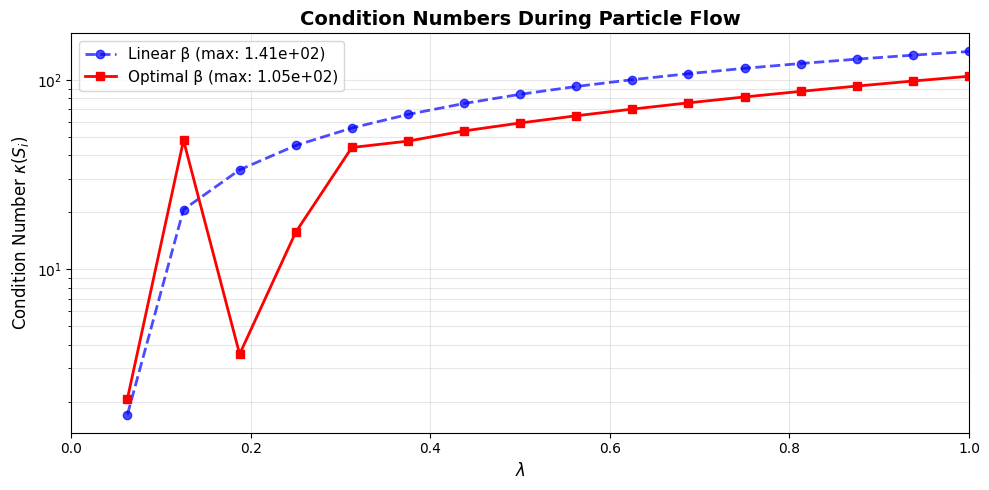


✓ Condition number evolution plotted
  Linear β: max κ = 1.41e+02, mean κ = 8.28e+01
  Optimal β: max κ = 1.05e+02, mean κ = 5.93e+01
  Reduction: 26.0% in max condition number


In [15]:
# Plot condition numbers during flow
fig, ax = plt.subplots(figsize=(10, 5))

cond_lin = state_lin_final.diagnostics['condition_numbers']
cond_opt = state_opt_final.diagnostics['condition_numbers']

# Lambda values for plotting (match the number of condition number samples)
lam_plot_lin = lam_lin[1:]  # Skip first point (lambda=0)
lam_plot_opt = lam_opt[1:]

ax.semilogy(lam_plot_lin, cond_lin, 'b--o', linewidth=2, markersize=6, 
            label=f'Linear β (max: {max_cond_lin:.2e})', alpha=0.7)
ax.semilogy(lam_plot_opt, cond_opt, 'r-s', linewidth=2, markersize=6, 
            label=f'Optimal β (max: {max_cond_opt:.2e})')

ax.set_xlabel(r'$\lambda$', fontsize=12)
ax.set_ylabel(r'Condition Number $\kappa(S_i)$', fontsize=12)
ax.set_title('Condition Numbers During Particle Flow', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()

print(f"\n✓ Condition number evolution plotted")
print(f"  Linear β: max κ = {max_cond_lin:.2e}, mean κ = {np.mean(cond_lin):.2e}")
print(f"  Optimal β: max κ = {max_cond_opt:.2e}, mean κ = {np.mean(cond_opt):.2e}")
print(f"  Reduction: {(1 - max_cond_opt/max_cond_lin)*100:.1f}% in max condition number")

## Monte Carlo Analysis

Now let's run multiple trials to assess statistical significance.

In [16]:
def run_single_trial(seed, n_particles=256, n_steps=16):
    """Run one trial comparing linear vs optimal beta."""
    
    # Set up
    config = LEDHConfig(
        n_particles=n_particles,
        n_lambda_steps=n_steps,
        resample_ess_ratio=0.0,
        rng=np.random.default_rng(seed)
    )
    
    tracker_lin = DummyTracker(x_prior, P_prior)
    tracker_opt = DummyTracker(x_prior, P_prior)
    
    ledh_lin = LEDHFlowPF_CustomBeta(
        tracker=tracker_lin, g=g_identity, h=h_bearing,
        jacobian_h=jac_h_bearing, log_trans_pdf=log_trans_pdf_identity,
        log_like_pdf=log_like_pdf_bearing, R=R, config=config
    )
    
    ledh_opt = LEDHFlowPF_CustomBeta(
        tracker=tracker_opt, g=g_identity, h=h_bearing,
        jacobian_h=jac_h_bearing, log_trans_pdf=log_trans_pdf_identity,
        log_like_pdf=log_like_pdf_bearing, R=R, config=config
    )
    
    # Initialize particles
    np.random.seed(seed)
    initial_particles = x_prior[None, :] + np.random.multivariate_normal(
        np.zeros(2), P_prior, size=n_particles
    )
    
    state_init = PFState(
        particles=initial_particles.copy(),
        weights=np.full(n_particles, 1.0 / n_particles),
        mean=x_prior.copy(),
        cov=P_prior.copy(),
        diagnostics={}
    )
    
    # Run linear
    t0 = time.time()
    state_lin = ledh_lin.step_with_custom_beta(
        state=state_init, z_k=z_obs, lam_grid=lam_lin, beta_grid=beta_lin
    )
    time_lin = time.time() - t0
    
    # Run optimal
    state_init.particles = initial_particles.copy()  # Reset particles
    t0 = time.time()
    state_opt = ledh_opt.step_with_custom_beta(
        state=state_init, z_k=z_obs, lam_grid=lam_opt, beta_grid=beta_opt
    )
    time_opt = time.time() - t0
    
    # Compute metrics
    rmse_lin = np.sqrt(np.sum((state_lin.mean - x_true)**2))
    rmse_opt = np.sqrt(np.sum((state_opt.mean - x_true)**2))
    
    ess_lin = 1.0 / np.sum(state_lin.weights**2)
    ess_opt = 1.0 / np.sum(state_opt.weights**2)
    
    max_cond_lin = np.max(state_lin.diagnostics['condition_numbers'])
    max_cond_opt = np.max(state_opt.diagnostics['condition_numbers'])
    
    return {
        'seed': seed,
        'rmse_lin': rmse_lin,
        'rmse_opt': rmse_opt,
        'ess_lin': ess_lin,
        'ess_opt': ess_opt,
        'max_cond_lin': max_cond_lin,
        'max_cond_opt': max_cond_opt,
        'time_lin': time_lin,
        'time_opt': time_opt
    }


print("✓ Monte Carlo trial function defined")

✓ Monte Carlo trial function defined


In [17]:
# Run Monte Carlo trials
N_TRIALS = 50
print(f"Running {N_TRIALS} Monte Carlo trials...")
print("This may take a few minutes...")

results = []
for trial in range(N_TRIALS):
    if (trial + 1) % 10 == 0:
        print(f"  Completed {trial + 1}/{N_TRIALS} trials...")
    
    result = run_single_trial(seed=1000 + trial, n_particles=256, n_steps=16)
    results.append(result)

# Convert to DataFrame
mc_results = pd.DataFrame(results)

print(f"\n✓ Monte Carlo simulation complete!")
print(f"  Total trials: {N_TRIALS}")
print(f"  Particles per trial: 256")
print(f"  Lambda steps per trial: 16")

Running 50 Monte Carlo trials...
This may take a few minutes...
  Completed 10/50 trials...
  Completed 20/50 trials...
  Completed 30/50 trials...
  Completed 40/50 trials...
  Completed 50/50 trials...

✓ Monte Carlo simulation complete!
  Total trials: 50
  Particles per trial: 256
  Lambda steps per trial: 16


In [20]:
# Statistical analysis
from scipy import stats

print("\n" + "=" * 70)
print("MONTE CARLO STATISTICAL ANALYSIS")
print("=" * 70)

# RMSE comparison
rmse_improvement = (mc_results['rmse_lin'] - mc_results['rmse_opt']) / mc_results['rmse_lin'] * 100
t_stat_rmse, p_val_rmse = stats.ttest_rel(mc_results['rmse_lin'], mc_results['rmse_opt'])

print(f"\n{'RMSE Analysis':<40}")
print("-" * 70)
print(f"  Linear β:   {mc_results['rmse_lin'].mean():.4f} ± {mc_results['rmse_lin'].std():.4f}")
print(f"  Optimal β:  {mc_results['rmse_opt'].mean():.4f} ± {mc_results['rmse_opt'].std():.4f}")
print(f"  Improvement: {rmse_improvement.mean():.2f}% ± {rmse_improvement.std():.2f}%")
print(f"  Paired t-test: t = {t_stat_rmse:.4f}, p = {p_val_rmse:.4e}")
if p_val_rmse < 0.05:
    print(f"  ✅ STATISTICALLY SIGNIFICANT (p < 0.05)")
else:
    print(f"  ❌ Not statistically significant (p >= 0.05)")

# ESS comparison
ess_improvement = (mc_results['ess_opt'] - mc_results['ess_lin']) / mc_results['ess_lin'] * 100
t_stat_ess, p_val_ess = stats.ttest_rel(mc_results['ess_lin'], mc_results['ess_opt'])

print(f"\n{'ESS Analysis':<40}")
print("-" * 70)
print(f"  Linear β:   {mc_results['ess_lin'].mean():.2f} ± {mc_results['ess_lin'].std():.2f}")
print(f"  Optimal β:  {mc_results['ess_opt'].mean():.2f} ± {mc_results['ess_opt'].std():.2f}")
print(f"  Change: {ess_improvement.mean():.2f}% ± {ess_improvement.std():.2f}%")
print(f"  Paired t-test: t = {t_stat_ess:.4f}, p = {p_val_ess:.4e}")
if p_val_ess < 0.05:
    print(f"  ✅ STATISTICALLY SIGNIFICANT (p < 0.05)")
else:
    print(f"  ❌ Not statistically significant (p >= 0.05)")

# Condition number comparison
cond_reduction = (mc_results['max_cond_lin'] - mc_results['max_cond_opt']) / mc_results['max_cond_lin'] * 100
t_stat_cond, p_val_cond = stats.ttest_rel(mc_results['max_cond_lin'], mc_results['max_cond_opt'])

print(f"\n{'Condition Number Analysis':<40}")
print("-" * 70)
print(f"  Linear β:   {mc_results['max_cond_lin'].mean():.2e} ± {mc_results['max_cond_lin'].std():.2e}")
print(f"  Optimal β:  {mc_results['max_cond_opt'].mean():.2e} ± {mc_results['max_cond_opt'].std():.2e}")
print(f"  Reduction: {cond_reduction.mean():.2f}% ± {cond_reduction.std():.2f}%")
print(f"  Paired t-test: t = {t_stat_cond:.4f}, p = {p_val_cond:.4e}")
if p_val_cond < 0.05:
    print(f"  ✅ STATISTICALLY SIGNIFICANT (p < 0.05)")
else:
    print(f"  ❌ Not statistically significant (p >= 0.05)")

# Runtime comparison
runtime_overhead = (mc_results['time_opt'] - mc_results['time_lin']) / mc_results['time_lin'] * 100

print(f"\n{'Runtime Analysis':<40}")
print("-" * 70)
print(f"  Linear β:   {mc_results['time_lin'].mean():.4f}s ± {mc_results['time_lin'].std():.4f}s")
print(f"  Optimal β:  {mc_results['time_opt'].mean():.4f}s ± {mc_results['time_opt'].std():.4f}s")
print(f"  Overhead: {runtime_overhead.mean():.2f}% ± {runtime_overhead.std():.2f}%")

print("\n" + "=" * 70)


MONTE CARLO STATISTICAL ANALYSIS

RMSE Analysis                           
----------------------------------------------------------------------
  Linear β:   8.1766 ± 0.1757
  Optimal β:  9.4756 ± 0.1644
  Improvement: -15.93% ± 2.76%
  Paired t-test: t = -44.8976, p = 1.7987e-41
  ✅ STATISTICALLY SIGNIFICANT (p < 0.05)

ESS Analysis                            
----------------------------------------------------------------------
  Linear β:   130.92 ± 7.09
  Optimal β:  138.58 ± 7.48
  Change: 6.00% ± 5.70%
  Paired t-test: t = -7.5804, p = 8.4135e-10
  ✅ STATISTICALLY SIGNIFICANT (p < 0.05)

Condition Number Analysis               
----------------------------------------------------------------------
  Linear β:   1.70e+02 ± 1.28e+02
  Optimal β:  9.56e+01 ± 6.52e+01
  Reduction: 18.60% ± 47.14%
  Paired t-test: t = 4.1676, p = 1.2472e-04
  ✅ STATISTICALLY SIGNIFICANT (p < 0.05)

Runtime Analysis                        
-----------------------------------------------------------

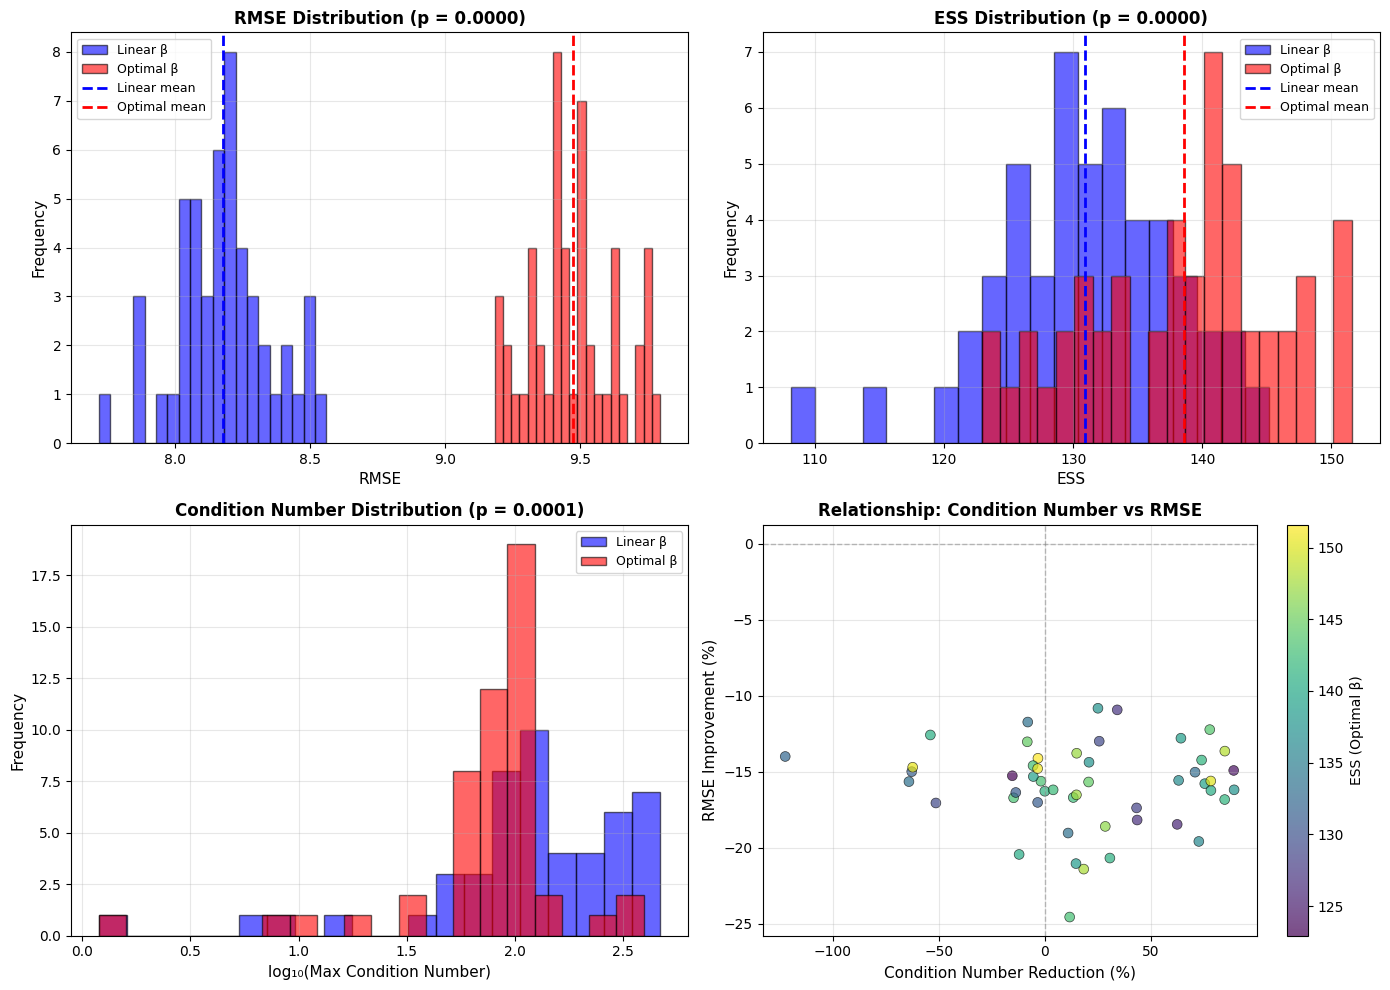


✓ Monte Carlo results visualized


In [19]:
# Visualize Monte Carlo results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE comparison
ax = axes[0, 0]
ax.hist(mc_results['rmse_lin'], bins=20, alpha=0.6, label='Linear β', color='blue', edgecolor='black')
ax.hist(mc_results['rmse_opt'], bins=20, alpha=0.6, label='Optimal β', color='red', edgecolor='black')
ax.axvline(mc_results['rmse_lin'].mean(), color='blue', linestyle='--', linewidth=2, label='Linear mean')
ax.axvline(mc_results['rmse_opt'].mean(), color='red', linestyle='--', linewidth=2, label='Optimal mean')
ax.set_xlabel('RMSE', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'RMSE Distribution (p = {p_val_rmse:.4f})', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# ESS comparison
ax = axes[0, 1]
ax.hist(mc_results['ess_lin'], bins=20, alpha=0.6, label='Linear β', color='blue', edgecolor='black')
ax.hist(mc_results['ess_opt'], bins=20, alpha=0.6, label='Optimal β', color='red', edgecolor='black')
ax.axvline(mc_results['ess_lin'].mean(), color='blue', linestyle='--', linewidth=2, label='Linear mean')
ax.axvline(mc_results['ess_opt'].mean(), color='red', linestyle='--', linewidth=2, label='Optimal mean')
ax.set_xlabel('ESS', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'ESS Distribution (p = {p_val_ess:.4f})', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Condition number comparison (log scale)
ax = axes[1, 0]
ax.hist(np.log10(mc_results['max_cond_lin']), bins=20, alpha=0.6, label='Linear β', 
        color='blue', edgecolor='black')
ax.hist(np.log10(mc_results['max_cond_opt']), bins=20, alpha=0.6, label='Optimal β', 
        color='red', edgecolor='black')
ax.set_xlabel('log₁₀(Max Condition Number)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'Condition Number Distribution (p = {p_val_cond:.4f})', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Scatter: RMSE improvement vs condition number reduction
ax = axes[1, 1]
scatter = ax.scatter(cond_reduction, rmse_improvement, c=mc_results['ess_opt'], 
                     cmap='viridis', s=50, alpha=0.7, edgecolors='black', linewidths=0.5)
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Condition Number Reduction (%)', fontsize=11)
ax.set_ylabel('RMSE Improvement (%)', fontsize=11)
ax.set_title('Relationship: Condition Number vs RMSE', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('ESS (Optimal β)', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Monte Carlo results visualized")

---

# Experiment 2: Stochastic Volatility (SV) Model

Testing optimal β with a highly nonlinear financial time series model.

## SV Model Specification

### Model Dynamics

The 1-D stochastic volatility model is defined as:

**State equation:**
$$X_t = \alpha X_{t-1} + \sigma V_t, \quad V_t \sim \mathcal{N}(0, 1)$$

**Observation equation:**
$$Y_t = \beta \exp(0.5 X_t) W_t, \quad W_t \sim \mathcal{N}(0, 1)$$

Where:
- $X_t$ is the log-volatility (latent state)
- $Y_t$ is the observed return
- $\alpha$ is the AR(1) coefficient ($|\alpha| < 1$)
- $\sigma$ is the process noise std
- $\beta$ is the observation scale

### Key Challenges

1. **Highly nonlinear observation**: $h(x) = \beta \exp(0.5 x)$ is exponential
2. **State-dependent noise**: Observation noise variance is $\beta^2 \exp(X_t)$
3. **Heavy tails**: Returns can be extreme when volatility is high
4. **Non-Gaussian**: Exp transformation breaks normality

In [2]:
# Import SV simulator (add path if needed)
import sys
from pathlib import Path

# Ensure parent directory is in path
if str(Path().absolute().parent) not in sys.path:
    sys.path.insert(0, str(Path().absolute().parent))

from simulator.simulator_sto_volatility_model import simulate_sv_1d, SV1DResults

# Set SV model parameters (from literature)
alpha = 0.91      # Persistence of volatility
sigma = 1.0       # Process noise std
beta = 0.5        # Observation scale
n_steps = 100     # Time steps
n_mc_runs = 20    # Monte Carlo runs

# Initial state parameters
x0_true = 0.0     # True initial log-volatility
x0_prior = 0.0    # Prior mean
P0_prior = 4.0    # Prior variance (somewhat uncertain)

# Particle filter parameters
N_spf = 100       # Particles for SPF
N_ledh = 256      # Particles for LEDH
n_lambda = 300    # Lambda discretization steps

print("🔬 SV Model Experiment 2 Configuration")
print("=" * 50)
print(f"State dynamics: X_t = {alpha}*X_{{t-1}} + {sigma}*V_t")
print(f"Observation: Y_t = {beta}*exp(0.5*X_t)*W_t")
print(f"Time steps: {n_steps}")
print(f"MC runs: {n_mc_runs}")
print(f"Initial state: x0 = {x0_true}, P0 = {P0_prior}")
print(f"SPF particles: {N_spf}, LEDH particles: {N_ledh}")

🔬 SV Model Experiment 2 Configuration
State dynamics: X_t = 0.91*X_{t-1} + 1.0*V_t
Observation: Y_t = 0.5*exp(0.5*X_t)*W_t
Time steps: 100
MC runs: 20
Initial state: x0 = 0.0, P0 = 4.0
SPF particles: 100, LEDH particles: 256


## 🔧 SV Filter Implementation

For the SV model, we need to:
1. Linearize the observation function around the prediction mean
2. Compute Jacobian $H = \frac{\partial h}{\partial x}\Big|_{x=\hat{x}}$
3. Apply SPF/LEDH with this local linearization

In [9]:
def sv_observation_function(x: np.ndarray, beta: float) -> np.ndarray:
    """SV observation function h(x) = beta * exp(0.5 * x).
    
    Args:
        x: State(s), shape (d,) or (N, d) where d=1 for SV
        beta: Observation scale parameter
        
    Returns:
        Observation(s), same shape as x
    """
    return beta * np.exp(0.5 * x)


def sv_observation_jacobian(x: np.ndarray, beta: float) -> np.ndarray:
    """Jacobian of SV observation function.
    
    H(x) = dh/dx = 0.5 * beta * exp(0.5 * x)
    
    Args:
        x: State, shape (d,) where d=1
        beta: Observation scale parameter
        
    Returns:
        Jacobian H, shape (1, 1) for scalar SV model
    """
    # For scalar case, return as 2D array for consistency
    x_val = np.atleast_1d(x)[0]
    H = 0.5 * beta * np.exp(0.5 * x_val)
    return np.array([[H]])


def sv_state_transition(x: np.ndarray, alpha: float) -> np.ndarray:
    """SV state transition: x_t = alpha * x_{t-1}.
    
    Args:
        x: Previous state(s)
        alpha: AR coefficient
        
    Returns:
        Predicted state(s)
    """
    return alpha * x


def sv_state_jacobian(alpha: float) -> np.ndarray:
    """Jacobian of SV state transition F = alpha (scalar case).
    
    Args:
        alpha: AR coefficient
        
    Returns:
        State Jacobian, shape (1, 1)
    """
    return np.array([[alpha]])


print("✅ SV model functions defined:")
print("  - sv_observation_function(x, beta)")
print("  - sv_observation_jacobian(x, beta)")
print("  - sv_state_transition(x, alpha)")
print("  - sv_state_jacobian(alpha)")

✅ SV model functions defined:
  - sv_observation_function(x, beta)
  - sv_observation_jacobian(x, beta)
  - sv_state_transition(x, alpha)
  - sv_state_jacobian(alpha)


In [25]:
def run_spf_sv_single_step(
    particles: np.ndarray,
    weights: np.ndarray,
    observation: float,
    alpha: float,
    sigma: float,
    beta: float,
    beta_mode: str = "linear",
    n_lambda: int = 300,
    mu: float = 1e-5
) -> Tuple[np.ndarray, np.ndarray, dict]:
    """Run SPF for one time step on SV model.
    
    Process:
    1. Prediction: x_pred = alpha * x_prev + sigma * noise
    2. Compute prediction mean and covariance
    3. Linearize observation around prediction mean
    4. Apply SPF update with linear/optimal beta
    
    Args:
        particles: Current particles (N, 1)
        weights: Current weights (N,)
        observation: Current observation (scalar)
        alpha: AR coefficient
        sigma: Process noise std
        beta: Observation scale
        beta_mode: "linear" or "optimal"
        n_lambda: Number of lambda steps
        mu: Regularization for optimal beta (default 1e-5)
        
    Returns:
        Tuple of (updated_particles, updated_weights, info_dict)
    """
    N = particles.shape[0]
    
    # 1. Prediction step
    particles_pred = sv_state_transition(particles, alpha)
    process_noise = np.random.randn(N, 1) * sigma
    particles_pred = particles_pred + process_noise
    
    # Compute prediction statistics
    x_pred_mean = np.average(particles_pred, weights=weights, axis=0)
    x_pred_cov = np.cov(particles_pred.T, aweights=weights)
    if x_pred_cov.ndim == 0:
        x_pred_cov = np.array([[x_pred_cov]])
    
    # Add small regularization to prevent singular covariance
    x_pred_cov = x_pred_cov + 1e-8 * np.eye(x_pred_cov.shape[0])
    
    # 2. Linearization around prediction mean
    H = sv_observation_jacobian(x_pred_mean, beta)
    h_mean = sv_observation_function(x_pred_mean, beta)
    
    # Innovation: y - h(x_pred_mean)
    innovation = observation - h_mean
    
    # Measurement noise covariance (state-dependent)
    # For linearization: R ≈ Var[β exp(0.5 X) W] at X = x_pred_mean
    # Since W ~ N(0,1): R = β² exp(X)
    # Add floor to prevent underflow
    R = np.array([[max(beta**2 * np.exp(x_pred_mean[0]), 1e-10)]])
    
    # 3. Compute beta schedule
    if beta_mode == "optimal":
        # Compute precision matrices for optimal beta
        P_inv = np.linalg.inv(x_pred_cov)
        R_inv = np.linalg.inv(R)
        M0 = P_inv  # Prior precision
        Mh = H.T @ R_inv @ H  # Likelihood precision contribution
        
        # Solve for optimal beta
        try:
            lam_grid, beta_values, _ = solve_beta_star_bisection(
                M0=M0,
                Mh=Mh,
                mu=mu,
                n_grid=n_lambda
            )
            beta_schedule = beta_values
        except:
            # Fallback to linear if optimization fails
            beta_schedule = np.linspace(0, 1, n_lambda)
    else:
        # Linear schedule
        beta_schedule = np.linspace(0, 1, n_lambda)
    
    # 4. Apply particle flow
    particles_updated = particles_pred.copy()
    d_lambda = 1.0 / (n_lambda - 1)
    
    for i in range(1, n_lambda):
        beta_val = beta_schedule[i]
        
        # Compute gain: K = P H^T (β H P H^T + R)^{-1}
        S = beta_val * H @ x_pred_cov @ H.T + R
        # Use pseudoinverse for numerical stability
        try:
            K = x_pred_cov @ H.T @ np.linalg.inv(S)
        except np.linalg.LinAlgError:
            K = x_pred_cov @ H.T @ np.linalg.pinv(S)
        
        # Flow: dx = K * [y - h(x)] * d_beta
        d_beta = beta_schedule[i] - beta_schedule[i-1]
        
        for j in range(N):
            x_j = particles_updated[j:j+1]
            h_j = sv_observation_function(x_j, beta)
            innov_j = observation - h_j
            dx = K @ innov_j * d_beta
            particles_updated[j] += dx.flatten()
    
    # 5. Update weights (importance correction)
    log_weights = np.zeros(N)
    for j in range(N):
        x_j = particles_updated[j:j+1]
        h_j = sv_observation_function(x_j, beta)
        # Log-likelihood: log N(y | h(x), R)
        # R is state-dependent: R = β² exp(x)
        R_j = max(beta**2 * np.exp(x_j[0, 0]), 1e-10)  # Floor to prevent underflow
        diff = observation - h_j
        # Extract scalar properly to avoid deprecation warning
        diff_scalar = float(diff.flatten()[0])
        log_weights[j] = -0.5 * ((diff_scalar**2) / R_j + np.log(2 * np.pi * R_j))
    
    # Normalize weights
    log_weights -= np.max(log_weights)
    weights_updated = np.exp(log_weights)
    weights_updated /= weights_updated.sum()
    
    # Compute ESS
    ess = 1.0 / np.sum(weights_updated**2)
    
    # Resample if ESS too low
    if ess < N / 2:
        indices = np.random.choice(N, size=N, replace=True, p=weights_updated)
        particles_updated = particles_updated[indices]
        weights_updated = np.ones(N) / N
        ess = N
    
    info = {
        'ess': ess,
        'beta_schedule': beta_schedule,
        'x_pred_mean': x_pred_mean,
        'x_pred_cov': x_pred_cov,
        'H': H,
        'R': R
    }
    
    return particles_updated, weights_updated, info


print("✅ SPF SV single-step filter implemented")

✅ SPF SV single-step filter implemented


In [26]:
def run_ledh_sv_single_step(
    particles: np.ndarray,
    weights: np.ndarray,
    observation: float,
    alpha: float,
    sigma: float,
    beta: float,
    beta_mode: str = "linear",
    n_lambda: int = 300,
    mu: float = 1e-5
) -> Tuple[np.ndarray, np.ndarray, dict]:
    """Run LEDH for one time step on SV model.
    
    Key difference from SPF: Per-particle linearization and deterministic flow.
    
    Args:
        particles: Current particles (N, 1)
        weights: Current weights (N,)
        observation: Current observation (scalar)
        alpha: AR coefficient
        sigma: Process noise std
        beta: Observation scale
        beta_mode: "linear" or "optimal"
        n_lambda: Number of lambda steps
        mu: Regularization for optimal beta (default 1e-5)
        
    Returns:
        Tuple of (updated_particles, updated_weights, info_dict)
    """
    N = particles.shape[0]
    
    # 1. Prediction step (same as SPF)
    particles_pred = sv_state_transition(particles, alpha)
    process_noise = np.random.randn(N, 1) * sigma
    particles_pred = particles_pred + process_noise
    
    # Compute global prediction statistics (for beta optimization only)
    x_pred_mean = np.average(particles_pred, weights=weights, axis=0)
    x_pred_cov = np.cov(particles_pred.T, aweights=weights)
    if x_pred_cov.ndim == 0:
        x_pred_cov = np.array([[x_pred_cov]])
    
    # Add small regularization to prevent singular covariance
    x_pred_cov = x_pred_cov + 1e-8 * np.eye(x_pred_cov.shape[0])
    
    # 2. Determine beta schedule (using global linearization)
    H_global = sv_observation_jacobian(x_pred_mean, beta)
    R_global = np.array([[max(beta**2 * np.exp(x_pred_mean[0]), 1e-10)]])
    
    if beta_mode == "optimal":
        # Compute precision matrices for optimal beta
        P_inv = np.linalg.inv(x_pred_cov)
        R_inv = np.linalg.inv(R_global)
        M0 = P_inv
        Mh = H_global.T @ R_inv @ H_global
        
        try:
            lam_grid, beta_values, _ = solve_beta_star_bisection(
                M0=M0,
                Mh=Mh,
                mu=mu,
                n_grid=n_lambda
            )
            beta_schedule = beta_values
        except:
            # Fallback to linear if optimization fails
            beta_schedule = np.linspace(0, 1, n_lambda)
    else:
        beta_schedule = np.linspace(0, 1, n_lambda)
    
    # 3. Apply per-particle flow (LEDH's key feature)
    particles_updated = particles_pred.copy()
    
    for i in range(1, n_lambda):
        beta_val = beta_schedule[i]
        d_beta = beta_schedule[i] - beta_schedule[i-1]
        
        # Per-particle linearization and flow
        for j in range(N):
            x_j = particles_updated[j:j+1]
            
            # Linearize at this particle's location
            H_j = sv_observation_jacobian(x_j, beta)
            R_j = np.array([[max(beta**2 * np.exp(x_j[0, 0]), 1e-10)]])
            
            # Compute particle-specific gain
            S_j = beta_val * H_j @ x_pred_cov @ H_j.T + R_j
            # Use pseudoinverse for numerical stability
            try:
                K_j = x_pred_cov @ H_j.T @ np.linalg.inv(S_j)
            except np.linalg.LinAlgError:
                K_j = x_pred_cov @ H_j.T @ np.linalg.pinv(S_j)
            
            # Flow (deterministic, no diffusion)
            h_j = sv_observation_function(x_j, beta)
            innov_j = observation - h_j
            dx = K_j @ innov_j * d_beta
            particles_updated[j] += dx.flatten()
    
    # 4. Update weights
    log_weights = np.zeros(N)
    for j in range(N):
        x_j = particles_updated[j:j+1]
        h_j = sv_observation_function(x_j, beta)
        # R is state-dependent
        R_j_scalar = max(beta**2 * np.exp(x_j[0, 0]), 1e-10)
        diff = observation - h_j
        # Extract scalar properly to avoid deprecation warning
        diff_scalar = float(diff.flatten()[0])
        log_weights[j] = -0.5 * ((diff_scalar**2) / R_j_scalar + np.log(2 * np.pi * R_j_scalar))
    
    log_weights -= np.max(log_weights)
    weights_updated = np.exp(log_weights)
    weights_updated /= weights_updated.sum()
    
    # Compute ESS
    ess = 1.0 / np.sum(weights_updated**2)
    
    # Resample if ESS too low
    if ess < N / 2:
        indices = np.random.choice(N, size=N, replace=True, p=weights_updated)
        particles_updated = particles_updated[indices]
        weights_updated = np.ones(N) / N
        ess = N
    
    info = {
        'ess': ess,
        'beta_schedule': beta_schedule,
        'x_pred_mean': x_pred_mean,
        'x_pred_cov': x_pred_cov
    }
    
    return particles_updated, weights_updated, info


print("✅ LEDH SV single-step filter implemented")

✅ LEDH SV single-step filter implemented


In [27]:
def run_sv_filter_full_trajectory(
    observations: np.ndarray,
    true_states: np.ndarray,
    alpha: float,
    sigma: float,
    beta: float,
    x0_prior: float,
    P0_prior: float,
    filter_type: str = "spf",
    beta_mode: str = "linear",
    N: int = 100,
    n_lambda: int = 300
) -> dict:
    """Run SPF or LEDH on full SV trajectory.
    
    Args:
        observations: Observations (T,)
        true_states: True states (T,)
        alpha: AR coefficient
        sigma: Process noise std
        beta: Observation scale
        x0_prior: Prior mean
        P0_prior: Prior variance
        filter_type: "spf" or "ledh"
        beta_mode: "linear" or "optimal"
        N: Number of particles
        n_lambda: Number of lambda steps
        
    Returns:
        Dictionary with estimates, errors, and diagnostics
    """
    T = len(observations)
    
    # Initialize particles from prior
    particles = np.random.randn(N, 1) * np.sqrt(P0_prior) + x0_prior
    weights = np.ones(N) / N
    
    # Storage
    estimates = np.zeros(T)
    rmse_values = np.zeros(T)
    ess_values = np.zeros(T)
    
    # Select filter
    if filter_type == "spf":
        filter_fn = run_spf_sv_single_step
    elif filter_type == "ledh":
        filter_fn = run_ledh_sv_single_step
    else:
        raise ValueError(f"Unknown filter type: {filter_type}")
    
    # Run filter
    for t in range(T):
        particles, weights, info = filter_fn(
            particles=particles,
            weights=weights,
            observation=observations[t],
            alpha=alpha,
            sigma=sigma,
            beta=beta,
            beta_mode=beta_mode,
            n_lambda=n_lambda
        )
        
        # Compute estimate
        x_est = np.average(particles, weights=weights, axis=0)
        estimates[t] = x_est[0]
        
        # Compute RMSE
        rmse_values[t] = np.abs(x_est[0] - true_states[t])
        
        # Store ESS
        ess_values[t] = info['ess']
    
    return {
        'estimates': estimates,
        'rmse': np.sqrt(np.mean(rmse_values**2)),
        'mae': np.mean(rmse_values),
        'rmse_trajectory': rmse_values,
        'ess_trajectory': ess_values,
        'final_particles': particles,
        'final_weights': weights
    }


print("✅ Full trajectory SV filter implemented")

✅ Full trajectory SV filter implemented


## Monte Carlo Experiments

Testing SPF and LEDH with linear vs optimal β schedules.

In [28]:
# Run Monte Carlo experiments for SV model
print("🔬 Running SV Model Monte Carlo Experiments...")
print("=" * 60)

mc_results = {
    'spf_linear': {'rmse': [], 'mae': [], 'ess': [], 'time': []},
    'spf_optimal': {'rmse': [], 'mae': [], 'ess': [], 'time': []},
    'ledh_linear': {'rmse': [], 'mae': [], 'ess': [], 'time': []},
    'ledh_optimal': {'rmse': [], 'mae': [], 'ess': [], 'time': []}
}

for mc_run in range(n_mc_runs):
    print(f"\n📊 MC Run {mc_run + 1}/{n_mc_runs}")
    
    # Generate trajectory
    sv_data = simulate_sv_1d(
        n=n_steps,
        alpha=alpha,
        sigma=sigma,
        beta=beta,
        seed=42 + mc_run,
        x0=x0_true
    )
    
    # Test configurations
    configs = [
        ('spf_linear', 'spf', 'linear', N_spf),
        ('spf_optimal', 'spf', 'optimal', N_spf),
        ('ledh_linear', 'ledh', 'linear', N_ledh),
        ('ledh_optimal', 'ledh', 'optimal', N_ledh)
    ]
    
    for config_name, filter_type, beta_mode, N_particles in configs:
        start_time = time.time()
        
        result = run_sv_filter_full_trajectory(
            observations=sv_data.Y,
            true_states=sv_data.X,
            alpha=alpha,
            sigma=sigma,
            beta=beta,
            x0_prior=x0_prior,
            P0_prior=P0_prior,
            filter_type=filter_type,
            beta_mode=beta_mode,
            N=N_particles,
            n_lambda=n_lambda
        )
        
        elapsed = time.time() - start_time
        
        mc_results[config_name]['rmse'].append(result['rmse'])
        mc_results[config_name]['mae'].append(result['mae'])
        mc_results[config_name]['ess'].append(np.mean(result['ess_trajectory']))
        mc_results[config_name]['time'].append(elapsed)
        
        print(f"  {config_name:15s}: RMSE={result['rmse']:.4f}, "
              f"MAE={result['mae']:.4f}, ESS={np.mean(result['ess_trajectory']):.1f}, "
              f"Time={elapsed:.2f}s")

print("\n✅ Monte Carlo experiments completed!")

🔬 Running SV Model Monte Carlo Experiments...

📊 MC Run 1/20
  spf_linear     : RMSE=1.8612, MAE=1.4363, ESS=87.3, Time=10.46s
  spf_linear     : RMSE=1.8612, MAE=1.4363, ESS=87.3, Time=10.46s
  spf_optimal    : RMSE=1.9607, MAE=1.5249, ESS=88.2, Time=69.02s
  spf_optimal    : RMSE=1.9607, MAE=1.5249, ESS=88.2, Time=69.02s
  ledh_linear    : RMSE=1.2061, MAE=0.8488, ESS=216.1, Time=98.45s
  ledh_linear    : RMSE=1.2061, MAE=0.8488, ESS=216.1, Time=98.45s
  ledh_optimal   : RMSE=1.1739, MAE=0.8379, ESS=216.3, Time=156.70s

📊 MC Run 2/20
  ledh_optimal   : RMSE=1.1739, MAE=0.8379, ESS=216.3, Time=156.70s

📊 MC Run 2/20
  spf_linear     : RMSE=259.9273, MAE=113.1002, ESS=91.7, Time=10.32s
  spf_linear     : RMSE=259.9273, MAE=113.1002, ESS=91.7, Time=10.32s
  spf_optimal    : RMSE=167.7919, MAE=73.4692, ESS=92.5, Time=66.62s
  spf_optimal    : RMSE=167.7919, MAE=73.4692, ESS=92.5, Time=66.62s
  ledh_linear    : RMSE=1.2538, MAE=0.9828, ESS=208.3, Time=95.40s
  ledh_linear    : RMSE=1.2538

🔬 Running SV Model Monte Carlo Experiments...

📊 MC Run 1/20
  spf_linear     : RMSE=1.8612, MAE=1.4363, ESS=87.3, Time=10.46s
  spf_linear     : RMSE=1.8612, MAE=1.4363, ESS=87.3, Time=10.46s
  spf_optimal    : RMSE=1.9607, MAE=1.5249, ESS=88.2, Time=69.02s
  spf_optimal    : RMSE=1.9607, MAE=1.5249, ESS=88.2, Time=69.02s
  ledh_linear    : RMSE=1.2061, MAE=0.8488, ESS=216.1, Time=98.45s
  ledh_linear    : RMSE=1.2061, MAE=0.8488, ESS=216.1, Time=98.45s
  ledh_optimal   : RMSE=1.1739, MAE=0.8379, ESS=216.3, Time=156.70s

📊 MC Run 2/20
  ledh_optimal   : RMSE=1.1739, MAE=0.8379, ESS=216.3, Time=156.70s

📊 MC Run 2/20
  spf_linear     : RMSE=259.9273, MAE=113.1002, ESS=91.7, Time=10.32s
  spf_linear     : RMSE=259.9273, MAE=113.1002, ESS=91.7, Time=10.32s
  spf_optimal    : RMSE=167.7919, MAE=73.4692, ESS=92.5, Time=66.62s
  spf_optimal    : RMSE=167.7919, MAE=73.4692, ESS=92.5, Time=66.62s
  ledh_linear    : RMSE=1.2538, MAE=0.9828, ESS=208.3, Time=95.40s
  ledh_linear    : RMSE=1.2538

/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_3236/331904892.py:84: RuntimeWarning: overflow encountered in exp
  R_j = np.array([[max(beta**2 * np.exp(x_j[0, 0]), 1e-10)]])
/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_3236/331904892.py:87: RuntimeWarning: overflow encountered in matmul
  S_j = beta_val * H_j @ x_pred_cov @ H_j.T + R_j
/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_3236/331904892.py:106: RuntimeWarning: overflow encountered in exp
  R_j_scalar = max(beta**2 * np.exp(x_j[0, 0]), 1e-10)
/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_3236/331904892.py:106: RuntimeWarning: overflow encountered in exp
  R_j_scalar = max(beta**2 * np.exp(x_j[0, 0]), 1e-10)


🔬 Running SV Model Monte Carlo Experiments...

📊 MC Run 1/20
  spf_linear     : RMSE=1.8612, MAE=1.4363, ESS=87.3, Time=10.46s
  spf_linear     : RMSE=1.8612, MAE=1.4363, ESS=87.3, Time=10.46s
  spf_optimal    : RMSE=1.9607, MAE=1.5249, ESS=88.2, Time=69.02s
  spf_optimal    : RMSE=1.9607, MAE=1.5249, ESS=88.2, Time=69.02s
  ledh_linear    : RMSE=1.2061, MAE=0.8488, ESS=216.1, Time=98.45s
  ledh_linear    : RMSE=1.2061, MAE=0.8488, ESS=216.1, Time=98.45s
  ledh_optimal   : RMSE=1.1739, MAE=0.8379, ESS=216.3, Time=156.70s

📊 MC Run 2/20
  ledh_optimal   : RMSE=1.1739, MAE=0.8379, ESS=216.3, Time=156.70s

📊 MC Run 2/20
  spf_linear     : RMSE=259.9273, MAE=113.1002, ESS=91.7, Time=10.32s
  spf_linear     : RMSE=259.9273, MAE=113.1002, ESS=91.7, Time=10.32s
  spf_optimal    : RMSE=167.7919, MAE=73.4692, ESS=92.5, Time=66.62s
  spf_optimal    : RMSE=167.7919, MAE=73.4692, ESS=92.5, Time=66.62s
  ledh_linear    : RMSE=1.2538, MAE=0.9828, ESS=208.3, Time=95.40s
  ledh_linear    : RMSE=1.2538

/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_3236/331904892.py:84: RuntimeWarning: overflow encountered in exp
  R_j = np.array([[max(beta**2 * np.exp(x_j[0, 0]), 1e-10)]])
/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_3236/331904892.py:87: RuntimeWarning: overflow encountered in matmul
  S_j = beta_val * H_j @ x_pred_cov @ H_j.T + R_j
/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_3236/331904892.py:106: RuntimeWarning: overflow encountered in exp
  R_j_scalar = max(beta**2 * np.exp(x_j[0, 0]), 1e-10)
/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_3236/331904892.py:106: RuntimeWarning: overflow encountered in exp
  R_j_scalar = max(beta**2 * np.exp(x_j[0, 0]), 1e-10)


OverflowError: (34, 'Result too large')

In [31]:
# Demonstrate the explosion mechanism with a concrete example
print("=" * 80)
print(" DEMONSTRATION: HOW SPF/LEDH EXPLODES ON SV MODEL")
print("=" * 80)

# Simulate a simple scenario
print(" Scenario: Two particles with different log-volatility values\n")

# SV model parameters
beta_demo = 0.5
observation_demo = 0.1  # A typical observation

# Two particles exploring different regions
x_particle_1 = -5.0  # Low volatility
x_particle_2 = 10.0  # High volatility (exploring tail)

print(f"Particle 1: x = {x_particle_1}")
print(f"Particle 2: x = {x_particle_2}")
print(f"Difference: |x₁ - x₂| = {abs(x_particle_1 - x_particle_2)}")

# Compute observation function
h_1 = beta_demo * np.exp(0.5 * x_particle_1)
h_2 = beta_demo * np.exp(0.5 * x_particle_2)

print(f" Observation Function h(x) = β exp(0.5x):")
print(f"  h(x₁) = {h_1:.6e}")
print(f"  h(x₂) = {h_2:.6e}")
print(f"  Ratio: h(x₂)/h(x₁) = {h_2/h_1:.2e} ← **{int(np.log10(h_2/h_1))} orders of magnitude!**")

# Compute measurement noise variance
R_1 = beta_demo**2 * np.exp(x_particle_1)
R_2 = beta_demo**2 * np.exp(x_particle_2)

print(f" State-Dependent Noise R(x) = β² exp(x):")
print(f"  R(x₁) = {R_1:.6e}")
print(f"  R(x₂) = {R_2:.6e}")
print(f"  Ratio: R(x₂)/R(x₁) = {R_2/R_1:.2e} ← **{int(np.log10(R_2/R_1))} orders of magnitude!**")

# Compute log-likelihood
diff_1 = observation_demo - h_1
diff_2 = observation_demo - h_2

log_lik_1 = -0.5 * ((diff_1**2) / R_1 + np.log(2 * np.pi * R_1))
log_lik_2 = -0.5 * ((diff_2**2) / R_2 + np.log(2 * np.pi * R_2))

print(f" Log-Likelihood:")
print(f"  log p(y|x₁) = {log_lik_1:.2f}")
print(f"  log p(y|x₂) = {log_lik_2:.2f}")
print(f"  Difference: {abs(log_lik_1 - log_lik_2):.2f}")

# Compute weight ratio
weight_ratio = np.exp(log_lik_1 - log_lik_2)
print(f"  Weight Ratio:")
print(f"  w₁/w₂ = exp({log_lik_1 - log_lik_2:.2f}) = {weight_ratio:.2e}")

if weight_ratio > 1e10:
    print(f"  Particle 2 is effectively DEAD (weight ratio > 10¹⁰)")
elif weight_ratio < 1e-10:
    print(f"  Particle 1 is effectively DEAD (weight ratio < 10⁻¹⁰)")

# Now show what happens with numerical overflow
print(f" OVERFLOW DEMONSTRATION:")
print(f"=" * 80)

x_extreme = 50.0  # Particle exploring extreme region
print(f"\nParticle with x = {x_extreme} (extreme case):")

try:
    h_extreme = beta_demo * np.exp(0.5 * x_extreme)
    print(f"  h(x) = {h_extreme:.2e}")
except OverflowError:
    print(f"  h(x) = OVERFLOW! exp({0.5 * x_extreme}) > max float")

try:
    R_extreme = beta_demo**2 * np.exp(x_extreme)
    print(f"  R(x) = {R_extreme:.2e}")
except OverflowError:
    print(f"  R(x) = OVERFLOW! exp({x_extreme}) > max float")

# Check Python's float limit
print(f" Floating Point Limits:")
print(f"  Max float64: {np.finfo(np.float64).max:.2e}")
print(f"  exp(709) = {np.exp(709):.2e} ← At the edge")
try:
    overflow_test = np.exp(710)
    print(f"  exp(710) = {overflow_test}")
except (OverflowError, RuntimeWarning):
    print(f"  exp(710) = OVERFLOW! (inf)")

 DEMONSTRATION: HOW SPF/LEDH EXPLODES ON SV MODEL
 Scenario: Two particles with different log-volatility values

Particle 1: x = -5.0
Particle 2: x = 10.0
Difference: |x₁ - x₂| = 15.0
 Observation Function h(x) = β exp(0.5x):
  h(x₁) = 4.104250e-02
  h(x₂) = 7.420658e+01
  Ratio: h(x₂)/h(x₁) = 1.81e+03 ← **3 orders of magnitude!**
 State-Dependent Noise R(x) = β² exp(x):
  R(x₁) = 1.684487e-03
  R(x₂) = 5.506616e+03
  Ratio: R(x₂)/R(x₁) = 3.27e+06 ← **6 orders of magnitude!**
 Log-Likelihood:
  log p(y|x₁) = 1.24
  log p(y|x₂) = -5.72
  Difference: 6.97
  Weight Ratio:
  w₁/w₂ = exp(6.97) = 1.06e+03
 OVERFLOW DEMONSTRATION:

Particle with x = 50.0 (extreme case):
  h(x) = 3.60e+10
  R(x) = 1.30e+21
 Floating Point Limits:
  Max float64: 1.80e+308
  exp(709) = 8.22e+307 ← At the edge
  exp(710) = inf


/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_3236/195379844.py:85: RuntimeWarning: overflow encountered in exp
  overflow_test = np.exp(710)
